In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame


In [63]:
client = CryptoHistoricalDataClient()

In [64]:
from datetime import timedelta

# Use last 60 days of minute bars — enough data without being millions of rows
start_date = datetime.now() - timedelta(days=60)

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Minute,
    start=start_date,
)

btc_bars = client.get_crypto_bars(request_params)
raw_df = btc_bars.df.reset_index()
raw_df = raw_df[raw_df["symbol"] == "BTC/USD"].copy()

print(f"Rows: {len(raw_df):,}  |  "
      f"From: {raw_df['timestamp'].min()}  →  {raw_df['timestamp'].max()}")
raw_df.head()

Rows: 82,908  |  From: 2025-12-25 13:10:00+00:00  →  2026-02-23 12:08:00+00:00


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2025-12-25 13:10:00+00:00,87439.9750,87471.2425,87432.1640,87446.9060,0.0,0.0,87451.70325
1,BTC/USD,2025-12-25 13:11:00+00:00,87438.9900,87449.4500,87422.7765,87449.4500,0.0,0.0,87436.11325
2,BTC/USD,2025-12-25 13:12:00+00:00,87446.3500,87446.3500,87429.7500,87443.0500,0.0,0.0,87438.05000
3,BTC/USD,2025-12-25 13:13:00+00:00,87454.0555,87454.0555,87439.5500,87445.9805,0.0,0.0,87446.80275
4,BTC/USD,2025-12-25 13:14:00+00:00,87463.4455,87490.5800,87455.5790,87455.5790,0.0,0.0,87473.07950


# Data Preparation & Technical Indicators

In [65]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = raw_df.copy()
df = df.sort_values("timestamp").reset_index(drop=True)

# ── Technical indicators ──────────────────────────────────────────────────────

# 1-minute return
df["return_1"]   = df["close"].pct_change()

# Momentum: close vs N minutes ago
df["momentum_5"]  = df["close"] - df["close"].shift(5)
df["momentum_10"] = df["close"] - df["close"].shift(10)

# Rolling moving averages
df["ma_5"]   = df["close"].rolling(5).mean()
df["ma_10"]  = df["close"].rolling(10).mean()
df["ma_20"]  = df["close"].rolling(20).mean()

# Price relative to moving averages (normalised signal)
df["close_vs_ma5"]  = df["close"] - df["ma_5"]
df["close_vs_ma10"] = df["close"] - df["ma_10"]

# Rolling volatility (std of returns)
df["volatility_10"] = df["return_1"].rolling(10).std()

# RSI-14
delta     = df["close"].diff()
gain      = delta.clip(lower=0).rolling(14).mean()
loss      = (-delta.clip(upper=0)).rolling(14).mean()
rs        = gain / loss.replace(0, 1e-9)
df["rsi"] = 100 - (100 / (1 + rs))

# Candle body & wick features
df["body"]       = df["close"] - df["open"]
df["upper_wick"] = df["high"]  - df[["close","open"]].max(axis=1)
df["lower_wick"] = df[["close","open"]].min(axis=1) - df["low"]

# Volume delta (change in volume)
df["volume_delta"] = df["volume"].diff()

# ── Target: direction (1 = next close HIGHER, 0 = lower or equal) ─────────────
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

df.dropna(inplace=True)

features = [
    "return_1", "momentum_5", "momentum_10",
    "close_vs_ma5", "close_vs_ma10",
    "volatility_10", "rsi",
    "body", "upper_wick", "lower_wick",
    "volume", "volume_delta", "trade_count",
]

X = df[features]
y = df["target"]

print(f"Dataset shape : {X.shape}")
print(f"Class balance : UP={y.mean():.2%}  DOWN={(1-y.mean()):.2%}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),      columns=features, index=X_test.index)

print(f"Train size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")
X_train_scaled.head()


Dataset shape : (82889, 13)
Class balance : UP=50.13%  DOWN=49.87%
Train size: (66311, 13), Test size: (16578, 13)


,return_1,momentum_5,momentum_10,close_vs_ma5,close_vs_ma10,volatility_10,rsi,body,upper_wick,lower_wick,volume,volume_delta,trade_count
19,0.321006,0.452836,0.516987,0.357512,0.417329,-0.358532,-0.106145,-0.018212,-0.191195,-0.035445,-0.070323,-3.854893e-19,-0.335783
20,-0.255777,0.064694,0.111435,0.002718,0.164436,-0.395902,-0.317270,-0.969611,-0.191195,-0.301005,0.080555,1.108801e-01,0.575679
21,-0.013493,0.121356,0.183472,-0.061272,0.118941,-0.405460,0.236329,-0.038169,-0.111019,0.623380,-0.066858,-1.083342e-01,1.487141
22,-0.178375,-0.124096,0.197232,-0.243335,-0.079056,-0.409224,-0.106301,-0.230736,-0.086129,-0.118170,-0.070323,-2.545877e-03,-0.335783
23,-0.086375,-0.142097,0.017968,-0.299756,-0.160756,-0.425010,0.545974,0.002620,-0.191195,-0.301005,-0.070323,-3.854893e-19,-0.335783


# Model Training – Random Forest Direction Classifier

Test Accuracy : 0.5436

              precision    recall  f1-score   support

        DOWN       0.54      0.51      0.52      8190
          UP       0.55      0.58      0.56      8388

    accuracy                           0.54     16578
   macro avg       0.54      0.54      0.54     16578
weighted avg       0.54      0.54      0.54     16578



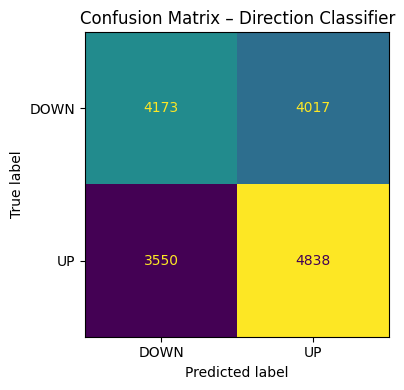

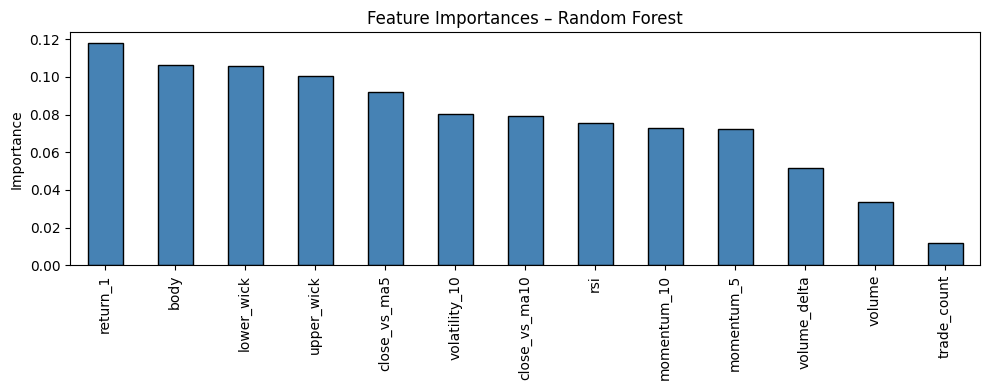

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_train_scaled, y_train)

y_pred      = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)[:, 1]  # probability of UP

print(f"Test Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print()
print(classification_report(y_test, y_pred, target_names=["DOWN", "UP"]))

# Confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
    display_labels=["DOWN", "UP"], colorbar=False, ax=ax)
ax.set_title("Confusion Matrix – Direction Classifier")
plt.tight_layout()
plt.show()

# Feature importances
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 4))
importances.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Feature Importances – Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## Overfitting / Underfitting Diagnostics

Train accuracy : 0.6840
Test  accuracy : 0.5436  (gap=0.1404)

Verdict: OVERFITTING  – train (0.6840) >> test (0.5436). Reduce max_depth or n_estimators.


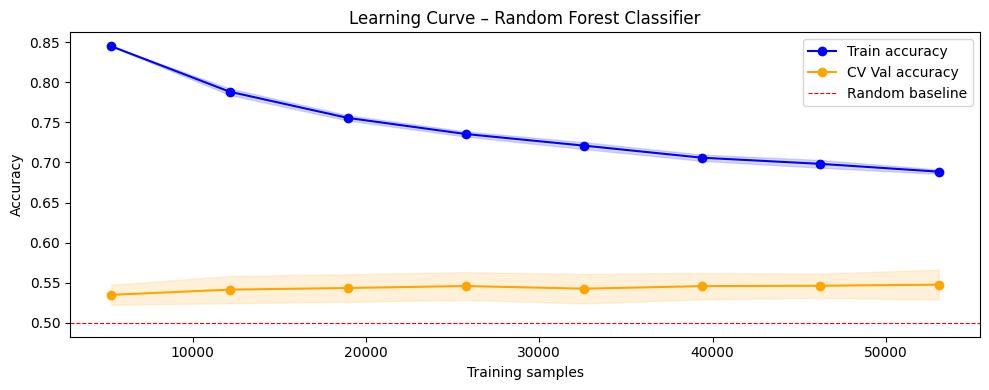

In [67]:
from sklearn.model_selection import learning_curve

# ── 1. Train vs Test accuracy ─────────────────────────────────────────────────
train_acc = accuracy_score(y_train, clf.predict(X_train_scaled))
test_acc  = accuracy_score(y_test,  y_pred)
gap       = train_acc - test_acc

print(f"Train accuracy : {train_acc:.4f}")
print(f"Test  accuracy : {test_acc:.4f}  (gap={gap:.4f})")

if train_acc < 0.55 and test_acc < 0.55:
    verdict = "UNDERFITTING – model barely beats random; add more/better features."
elif gap > 0.10:
    verdict = f"OVERFITTING  – train ({train_acc:.4f}) >> test ({test_acc:.4f}). Reduce max_depth or n_estimators."
else:
    verdict = f"GOOD FIT     – train/test close (gap={gap:.4f})."
print(f"\nVerdict: {verdict}")

# ── 2. Learning curve ─────────────────────────────────────────────────────────
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    X_train_scaled, y_train,
    cv=5, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)
plt.figure(figsize=(10, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", color="blue",   label="Train accuracy")
plt.plot(train_sizes, val_scores.mean(axis=1),   "o-", color="orange", label="CV Val accuracy")
plt.fill_between(train_sizes,
    train_scores.mean(axis=1) - train_scores.std(axis=1),
    train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.15, color="blue")
plt.fill_between(train_sizes,
    val_scores.mean(axis=1) - val_scores.std(axis=1),
    val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.15, color="orange")
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8, label="Random baseline")
plt.title("Learning Curve – Random Forest Classifier")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


## Strategy Backtest – Does Following the Model Make Money?

Confidence bucket  |  Signals  |  Accuracy
---------------------------------------------
  50-60%         |   14,374  |  53.11%
  60-70%         |    2,197  |  62.40%
  70-80%         |        1  |  0.00%
  80-90%         |        3  |  100.00%
  90-100%        |        3  |  100.00%

Precision UP   : 0.5464  (of predicted UP, how many were actually UP?)
Precision DOWN : 0.5403  (of predicted DOWN, how many were actually DOWN?)
Recall    UP   : 0.5768  (of actual UP moves, how many did the model catch?)
Recall    DOWN : 0.5095

── Backtest on test set (16,577 minutes) ──
Strategy total P&L  : $+55,955.26
Buy-and-hold P&L    : $-1,262.45
Win rate            : 54.35%
Average gain/trade  : $+3.38


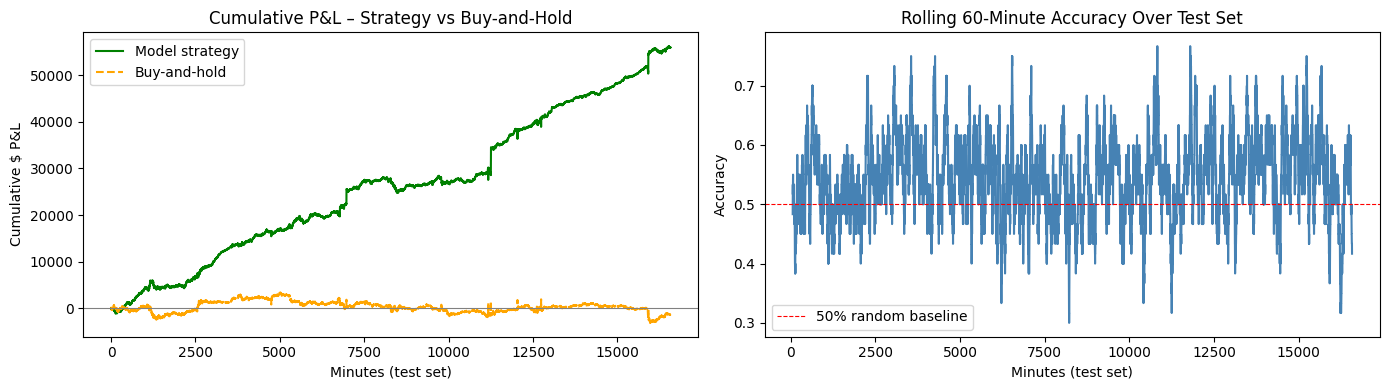

In [68]:

# ── What to look at ───────────────────────────────────────────────────────────
# 1. Accuracy broken down by confidence  → only trust high-confidence signals
# 2. Precision/Recall per class          → is it biased toward UP or DOWN?
# 3. Simulated P&L backtest              → does following the model beat buy-and-hold?

from sklearn.metrics import precision_score, recall_score

# ── 1. Accuracy by confidence bucket ─────────────────────────────────────────
confidence    = np.maximum(y_pred_prob, 1 - y_pred_prob)
bucket_labels = ["50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
bucket_edges  = [0.50, 0.60, 0.70, 0.80, 0.90, 1.01]

print("Confidence bucket  |  Signals  |  Accuracy")
print("-" * 45)
for i in range(len(bucket_edges) - 1):
    mask = (confidence >= bucket_edges[i]) & (confidence < bucket_edges[i+1])
    n    = mask.sum()
    if n == 0:
        print(f"  {bucket_labels[i]:13s}  |  {'0':>7}  |  —")
        continue
    acc  = accuracy_score(y_test[mask], y_pred[mask])
    print(f"  {bucket_labels[i]:13s}  |  {n:>7,}  |  {acc:.2%}")

# ── 2. Precision & Recall ─────────────────────────────────────────────────────
print(f"\nPrecision UP   : {precision_score(y_test, y_pred, pos_label=1):.4f}  "
      f"(of predicted UP, how many were actually UP?)")
print(f"Precision DOWN : {precision_score(y_test, y_pred, pos_label=0):.4f}  "
      f"(of predicted DOWN, how many were actually DOWN?)")
print(f"Recall    UP   : {recall_score(y_test, y_pred, pos_label=1):.4f}  "
      f"(of actual UP moves, how many did the model catch?)")
print(f"Recall    DOWN : {recall_score(y_test, y_pred, pos_label=0):.4f}")

# ── 3. Simulated P&L backtest ─────────────────────────────────────────────────
# Strategy: if model says UP → go long next minute, if DOWN → go short
# Compare against: always long (buy-and-hold) using the same test period

test_closes  = df.loc[y_test.index, "close"].values
actual_moves = np.diff(test_closes)           # actual $ move each minute
signals      = y_pred[:-1]                    # aligned signals (drop last)
# +1 if long (UP signal), -1 if short (DOWN signal)
strategy_pnl = np.where(signals == 1, actual_moves, -actual_moves)
bah_pnl      = actual_moves                   # buy-and-hold

strat_cumulative = np.concatenate([[0], np.cumsum(strategy_pnl)])
bah_cumulative   = np.concatenate([[0], np.cumsum(bah_pnl)])

print(f"\n── Backtest on test set ({len(actual_moves):,} minutes) ──")
print(f"Strategy total P&L  : ${strategy_pnl.sum():+,.2f}")
print(f"Buy-and-hold P&L    : ${bah_pnl.sum():+,.2f}")
print(f"Win rate            : {(strategy_pnl > 0).mean():.2%}")
print(f"Average gain/trade  : ${strategy_pnl.mean():+.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(strat_cumulative, color="green",  label="Model strategy")
axes[0].plot(bah_cumulative,   color="orange", label="Buy-and-hold", linestyle="--")
axes[0].axhline(0, color="grey", linewidth=0.8)
axes[0].set_title("Cumulative P&L – Strategy vs Buy-and-Hold")
axes[0].set_xlabel("Minutes (test set)")
axes[0].set_ylabel("Cumulative $ P&L")
axes[0].legend()

# Rolling 60-minute accuracy
rolling_correct = pd.Series((y_pred == y_test.values).astype(int)).rolling(60).mean()
axes[1].plot(rolling_correct, color="steelblue")
axes[1].axhline(0.5, color="red", linestyle="--", linewidth=0.8, label="50% random baseline")
axes[1].set_title("Rolling 60-Minute Accuracy Over Test Set")
axes[1].set_xlabel("Minutes (test set)")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


# Next-5-Minutes Prediction Bot

In [69]:
# Retrain classifier on ALL available data for the most up-to-date model
from sklearn.ensemble import RandomForestClassifier

scaler_full = StandardScaler()
X_full = df[features]
y_full = df["target"]

X_full_scaled = pd.DataFrame(scaler_full.fit_transform(X_full), columns=features, index=X_full.index)

clf_full = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
clf_full.fit(X_full_scaled, y_full)
print("Classifier retrained on full dataset.")

Classifier retrained on full dataset.


Last known candle: 2026-02-23 07:08 ET  close=$66,248.43

  07:09 ET  →  ▼ DOWN   (UP 47.1% / DOWN 52.9%)  confidence=52.9%
  07:10 ET  →  ▲ UP   (UP 53.4% / DOWN 46.6%)  confidence=53.4%
  07:11 ET  →  ▼ DOWN   (UP 41.2% / DOWN 58.8%)  confidence=58.8%
  07:12 ET  →  ▲ UP   (UP 56.3% / DOWN 43.7%)  confidence=56.3%
  07:13 ET  →  ▼ DOWN   (UP 44.8% / DOWN 55.2%)  confidence=55.2%


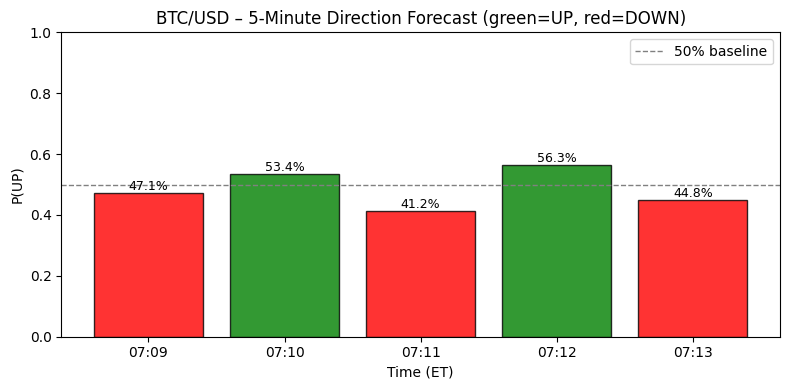

In [70]:
# Predict direction for the next 5 minutes from the latest real candle
import pytz

eastern   = pytz.timezone("America/New_York")
last_time = pd.to_datetime(df.iloc[-1]["timestamp"], utc=True).astimezone(eastern)
print(f"Last known candle: {last_time.strftime('%Y-%m-%d %H:%M')} ET  "
      f"close=${df.iloc[-1]['close']:,.2f}\n")

# Use the last row's already-computed feature values from df
last_feat = df[features].iloc[[-1]]
last_feat_scaled = pd.DataFrame(
    scaler_full.transform(last_feat), columns=features
)

# Iteratively predict 5 steps, rolling the feature window forward
# We append synthetic rows to a working copy of df to recompute indicators
work = df.copy()

results = []
for step in range(1, 6):
    future_time = last_time + pd.Timedelta(minutes=step)

    # Predict from current last row
    feat_row = work[features].iloc[[-1]]
    feat_scaled = pd.DataFrame(scaler_full.transform(feat_row), columns=features)

    prob_up  = clf_full.predict_proba(feat_scaled)[0][1]
    prob_dn  = 1 - prob_up
    direction = "▲ UP" if prob_up >= 0.5 else "▼ DOWN"
    confidence = max(prob_up, prob_dn)

    print(f"  {future_time.strftime('%H:%M')} ET  →  {direction}   "
          f"(UP {prob_up:.1%} / DOWN {prob_dn:.1%})  confidence={confidence:.1%}")

    results.append({
        "time": future_time.strftime("%H:%M"),
        "prob_up": prob_up,
        "direction": "UP" if prob_up >= 0.5 else "DOWN"
    })

    # Simulate next candle: if UP predicted, nudge close up; else down
    last_close = work["close"].iloc[-1]
    sim_close  = last_close * (1 + 0.0001) if prob_up >= 0.5 else last_close * (1 - 0.0001)
    new_row = work.iloc[-1].copy()
    new_row["close"]  = sim_close
    new_row["open"]   = last_close
    new_row["high"]   = max(last_close, sim_close)
    new_row["low"]    = min(last_close, sim_close)
    work = pd.concat([work, new_row.to_frame().T], ignore_index=True)

    # Recompute rolling indicators on extended work frame
    work["return_1"]      = work["close"].pct_change()
    work["momentum_5"]    = work["close"] - work["close"].shift(5)
    work["momentum_10"]   = work["close"] - work["close"].shift(10)
    work["ma_5"]          = work["close"].rolling(5).mean()
    work["ma_10"]         = work["close"].rolling(10).mean()
    work["ma_20"]         = work["close"].rolling(20).mean()
    work["close_vs_ma5"]  = work["close"] - work["ma_5"]
    work["close_vs_ma10"] = work["close"] - work["ma_10"]
    work["volatility_10"] = work["return_1"].rolling(10).std()
    delta = work["close"].diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = (-delta.clip(upper=0)).rolling(14).mean()
    work["rsi"]           = 100 - (100 / (1 + gain / loss.replace(0, 1e-9)))
    work["body"]          = work["close"] - work["open"]
    work["upper_wick"]    = work["high"] - work[["close","open"]].max(axis=1)
    work["lower_wick"]    = work[["close","open"]].min(axis=1) - work["low"]
    work["volume_delta"]  = work["volume"].diff()

# Plot probability bars
res_df = pd.DataFrame(results)
colors = ["green" if d == "UP" else "red" for d in res_df["direction"]]

plt.figure(figsize=(8, 4))
bars = plt.bar(res_df["time"], res_df["prob_up"], color=colors, edgecolor="black", alpha=0.8)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=1, label="50% baseline")
for bar, val in zip(bars, res_df["prob_up"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{val:.1%}", ha="center", fontsize=9)
plt.ylim(0, 1)
plt.title("BTC/USD – 5-Minute Direction Forecast (green=UP, red=DOWN)")
plt.xlabel("Time (ET)")
plt.ylabel("P(UP)")
plt.legend()
plt.tight_layout()
plt.show()


# Manual Input Prediction
Set your start price and time below, then run the next cell.

Auto time (ET): 07:20  |  price = $66,191.79
Window: 07:20 → 07:25 ET

  07:21 ET  →  ▲ UP   (UP 56.3% / DOWN 43.7%)
  07:22 ET  →  ▼ DOWN   (UP 48.3% / DOWN 51.7%)
  07:23 ET  →  ▲ UP   (UP 60.1% / DOWN 39.9%)
  07:24 ET  →  ▼ DOWN   (UP 48.4% / DOWN 51.6%)
  07:25 ET  →  ▲ UP   (UP 57.8% / DOWN 42.2%)

  OVERALL 07:20 → 07:25 ET
  Direction  : ▲ UP   (3 UP  /  2 DOWN votes)
  Avg P(UP)  : 54.2%
  Start price: $66,191.79
  End price  : $66,198.41  (simulated Δ +6.62)
Logged prediction to prediction_log.csv



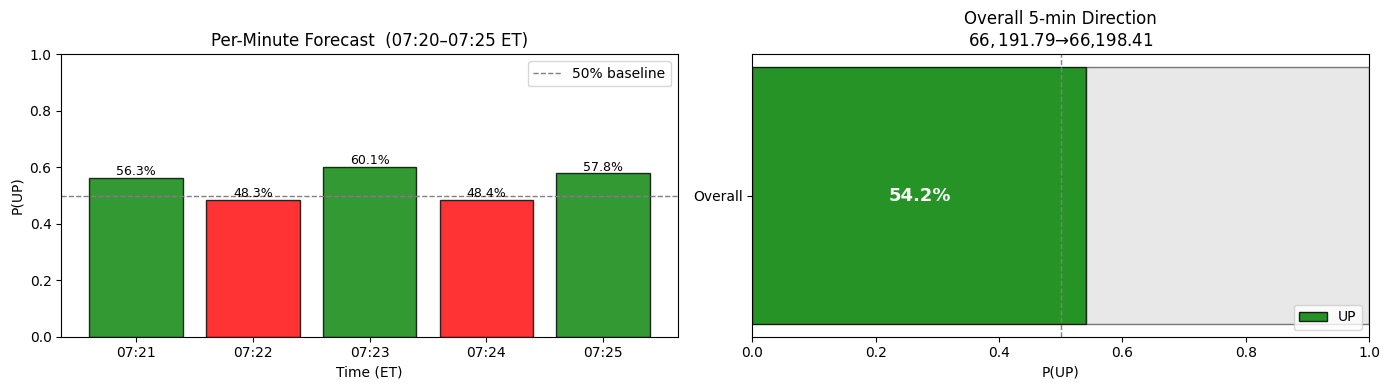

In [79]:
import os
import pytz
from datetime import datetime, timedelta

# ── USER INPUT ────────────────────────────────────────────────────────────────
input_price = 66191.79              # your starting BTC/USD price (no commas!)
CHECK_DELAY_MIN = 10                 # wait this long before scoring past predictions
LOG_PATH = "prediction_log.csv"
TIME_STEP_MIN = 5
# ─────────────────────────────────────────────────────────────────────────────

eastern = pytz.timezone("America/New_York")
now_et = datetime.now(eastern).replace(second=0, microsecond=0)
start_dt = now_et - timedelta(minutes=now_et.minute % TIME_STEP_MIN)
end_time = start_dt + pd.Timedelta(minutes=TIME_STEP_MIN)
input_time = start_dt.strftime("%Y-%m-%d %H:%M")

print(f"Auto time (ET): {start_dt.strftime('%H:%M')}  |  price = ${input_price:,.2f}")
print(f"Window: {start_dt.strftime('%H:%M')} → {end_time.strftime('%H:%M')} ET\n")

# Build an ET time index for quick lookups of actual closes
df_times_et = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert(eastern).dt.floor("min")
close_by_time = pd.Series(df["close"].values, index=df_times_et)

def get_close_at(dt_et):
    dt_et = dt_et.replace(second=0, microsecond=0)
    return close_by_time.get(dt_et, np.nan)

# Update previous predictions if enough time has passed
if os.path.exists(LOG_PATH):
    log_df = pd.read_csv(LOG_PATH)
else:
    log_df = pd.DataFrame(columns=[
        "start_time", "end_time", "input_price", "overall_dir", "avg_prob_up",
        "pred_end_price", "actual_end_price", "actual_dir", "correct", "status", "logged_at"
    ])

if not log_df.empty:
    if "status" not in log_df.columns:
        log_df["status"] = "pending"
    end_dt = pd.to_datetime(log_df["end_time"])
    eligible = (log_df["status"] == "pending") & (end_dt <= now_et - timedelta(minutes=CHECK_DELAY_MIN))
    updated = 0
    for idx in log_df[eligible].index:
        end_dt_i = pd.to_datetime(log_df.at[idx, "end_time"]).to_pydatetime()
        actual_close = get_close_at(end_dt_i)
        if pd.isna(actual_close):
            continue
        input_price_i = float(log_df.at[idx, "input_price"])
        actual_dir = "UP" if actual_close > input_price_i else "DOWN"
        correct = (actual_dir == log_df.at[idx, "overall_dir"])
        log_df.at[idx, "actual_end_price"] = actual_close
        log_df.at[idx, "actual_dir"] = actual_dir
        log_df.at[idx, "correct"] = bool(correct)
        log_df.at[idx, "status"] = "scored"
        updated += 1
    if updated > 0:
        print(f"Scored {updated} previous predictions (>= {CHECK_DELAY_MIN} min old).\n")

# Seed with real recent data then override the last close with input_price
work = df.copy()
last_row = work.iloc[-1].copy()
last_row["close"] = input_price
last_row["open"]  = input_price
last_row["high"]  = input_price
last_row["low"]   = input_price
work = pd.concat([work, last_row.to_frame().T], ignore_index=True)

# Recompute indicators after injecting the input price
work["return_1"]      = work["close"].pct_change()
work["momentum_5"]    = work["close"] - work["close"].shift(5)
work["momentum_10"]   = work["close"] - work["close"].shift(10)
work["ma_5"]          = work["close"].rolling(5).mean()
work["ma_10"]         = work["close"] - work["close"].shift(10)
work["ma_20"]         = work["close"].rolling(20).mean()
work["close_vs_ma5"]  = work["close"] - work["ma_5"]
work["close_vs_ma10"] = work["close"] - work["ma_10"]
work["volatility_10"] = work["return_1"].rolling(10).std()
delta = work["close"].diff()
gain  = delta.clip(lower=0).rolling(14).mean()
loss  = (-delta.clip(upper=0)).rolling(14).mean()
work["rsi"]           = 100 - (100 / (1 + gain / loss.replace(0, 1e-9)))
work["body"]          = work["close"] - work["open"]
work["upper_wick"]    = work["high"] - work[["close", "open"]].max(axis=1)
work["lower_wick"]    = work[["close", "open"]].min(axis=1) - work["low"]
work["volume_delta"]  = work["volume"].diff()

results = []
sim_price = float(input_price)  # track simulated price through each step

for step in range(1, 6):
    future_time = start_dt + pd.Timedelta(minutes=step)

    feat_row    = work[features].iloc[[-1]]
    feat_scaled = pd.DataFrame(scaler_full.transform(feat_row), columns=features)

    prob_up   = clf_full.predict_proba(feat_scaled)[0][1]
    prob_dn   = 1 - prob_up
    direction = "▲ UP" if prob_up >= 0.5 else "▼ DOWN"

    print(f"  {future_time.strftime('%H:%M')} ET  →  {direction}   "
          f"(UP {prob_up:.1%} / DOWN {prob_dn:.1%})")

    results.append({
        "time": future_time.strftime("%H:%M"),
        "prob_up": prob_up,
        "direction": "UP" if prob_up >= 0.5 else "DOWN"
    })

    # Roll forward
    last_close = work["close"].iloc[-1]
    sim_close  = last_close * (1 + 0.0001) if prob_up >= 0.5 else last_close * (1 - 0.0001)
    sim_price  = float(sim_close)
    new_row = work.iloc[-1].copy()
    new_row["close"] = sim_close
    new_row["open"]  = last_close
    new_row["high"]  = max(last_close, sim_close)
    new_row["low"]   = min(last_close, sim_close)
    work = pd.concat([work, new_row.to_frame().T], ignore_index=True)

    work["return_1"]      = work["close"].pct_change()
    work["momentum_5"]    = work["close"] - work["close"].shift(5)
    work["momentum_10"]   = work["close"] - work["close"].shift(10)
    work["ma_5"]          = work["close"].rolling(5).mean()
    work["ma_10"]         = work["close"].rolling(10).mean()
    work["ma_20"]         = work["close"].rolling(20).mean()
    work["close_vs_ma5"]  = work["close"] - work["ma_5"]
    work["close_vs_ma10"] = work["close"] - work["ma_10"]
    work["volatility_10"] = work["return_1"].rolling(10).std()
    delta = work["close"].diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = (-delta.clip(upper=0)).rolling(14).mean()
    work["rsi"]           = 100 - (100 / (1 + gain / loss.replace(0, 1e-9)))
    work["body"]          = work["close"] - work["open"]
    work["upper_wick"]    = work["high"] - work[["close", "open"]].max(axis=1)
    work["lower_wick"]    = work[["close", "open"]].min(axis=1) - work["low"]
    work["volume_delta"]  = work["volume"].diff()

# ── Overall 5-minute summary ──────────────────────────────────────────────────
res_df      = pd.DataFrame(results)
avg_prob_up = res_df["prob_up"].mean()
up_votes    = (res_df["direction"] == "UP").sum()
dn_votes    = (res_df["direction"] == "DOWN").sum()
price_delta = sim_price - input_price
overall_dir = "UP" if avg_prob_up >= 0.5 else "DOWN"
overall_col = "green" if avg_prob_up >= 0.5 else "red"

print(f"\n{'='*52}")
print(f"  OVERALL {start_dt.strftime('%H:%M')} → {end_time.strftime('%H:%M')} ET")
print(f"  Direction  : {'▲ UP' if overall_dir == 'UP' else '▼ DOWN'}   ({up_votes} UP  /  {dn_votes} DOWN votes)")
print(f"  Avg P(UP)  : {avg_prob_up:.1%}")
print(f"  Start price: ${input_price:,.2f}")
print(f"  End price  : ${sim_price:,.2f}  (simulated Δ {price_delta:+.2f})")
print(f"{'='*52}")

# Log the current prediction
new_row = {
    "start_time": start_dt.isoformat(),
    "end_time": end_time.isoformat(),
    "input_price": float(input_price),
    "overall_dir": overall_dir,
    "avg_prob_up": float(avg_prob_up),
    "pred_end_price": float(sim_price),
    "actual_end_price": np.nan,
    "actual_dir": "",
    "correct": np.nan,
    "status": "pending",
    "logged_at": datetime.now(eastern).isoformat(),
}
log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)
log_df.to_csv(LOG_PATH, index=False)
print(f"Logged prediction to {LOG_PATH}\n")

# ── Per-minute bar chart ──────────────────────────────────────────────────────
colors = ["green" if d == "UP" else "red" for d in res_df["direction"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: per-minute bars
bars = axes[0].bar(res_df["time"], res_df["prob_up"], color=colors, edgecolor="black", alpha=0.8)
axes[0].axhline(0.5, color="grey", linestyle="--", linewidth=1, label="50% baseline")
for bar, val in zip(bars, res_df["prob_up"]):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{val:.1%}", ha="center", fontsize=9)
axes[0].set_ylim(0, 1)
axes[0].set_title(f"Per-Minute Forecast  ({start_dt.strftime('%H:%M')}–{end_time.strftime('%H:%M')} ET)")
axes[0].set_xlabel("Time (ET)")
axes[0].set_ylabel("P(UP)")
axes[0].legend()

# Right: overall summary gauge bar
axes[1].barh(["Overall"], [avg_prob_up], color=overall_col, edgecolor="black", alpha=0.85, label=overall_dir)
axes[1].barh(["Overall"], [1 - avg_prob_up], left=[avg_prob_up],
             color="lightgrey", edgecolor="black", alpha=0.5)
axes[1].axvline(0.5, color="grey", linestyle="--", linewidth=1)
axes[1].set_xlim(0, 1)
axes[1].set_title(f"Overall 5-min Direction\n${input_price:,.2f} → ${sim_price:,.2f}")
axes[1].set_xlabel("P(UP)")
axes[1].text(avg_prob_up / 2, 0, f"{avg_prob_up:.1%}", ha="center", va="center",
             fontsize=13, fontweight="bold", color="white")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [77]:
# Testing: evaluate model errors on holdout test set
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, log_loss, brier_score_loss
 )

# Basic metrics
test_pred = clf.predict(X_test_scaled)
test_prob = clf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, test_pred)
auc = roc_auc_score(y_test, test_prob)
ll  = log_loss(y_test, test_prob)
brier = brier_score_loss(y_test, test_prob)

print("=== Test Set Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}  (0.5 = random, 1.0 = perfect)")
print(f"Log loss : {ll:.4f}  (lower is better)")
print(f"Brier    : {brier:.4f}  (lower is better)")
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=["DOWN", "UP"]))

# Confusion matrix with counts
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix [rows=actual, cols=pred]:")
print(cm)

# Show a few worst mistakes (high confidence, wrong)
mistakes = pd.DataFrame({
    "timestamp": df.loc[y_test.index, "timestamp"],
    "close": df.loc[y_test.index, "close"],
    "actual": y_test.values,
    "pred": test_pred,
    "prob_up": test_prob,
})
mistakes = mistakes[mistakes["actual"] != mistakes["pred"]].copy()
mistakes["confidence"] = np.maximum(mistakes["prob_up"], 1 - mistakes["prob_up"])
mistakes = mistakes.sort_values("confidence", ascending=False).head(10)

print("\nTop 10 high-confidence errors:")
display(mistakes)

=== Test Set Metrics ===
Accuracy : 0.5436
ROC AUC  : 0.5673  (0.5 = random, 1.0 = perfect)
Log loss : 0.6857  (lower is better)
Brier    : 0.2463  (lower is better)

Classification report:
              precision    recall  f1-score   support

        DOWN       0.54      0.51      0.52      8190
          UP       0.55      0.58      0.56      8388

    accuracy                           0.54     16578
   macro avg       0.54      0.54      0.54     16578
weighted avg       0.54      0.54      0.54     16578

Confusion matrix [rows=actual, cols=pred]:
[[4173 4017]
 [3550 4838]]

Top 10 high-confidence errors:


,timestamp,close,actual,pred,prob_up,confidence
80109,2026-02-21 11:07:00+00:00,68243.2010,1,0,0.298839,0.701161
79896,2026-02-21 07:08:00+00:00,67809.1205,1,0,0.306812,0.693188
72591,2026-02-16 04:50:00+00:00,68728.6210,1,0,0.313513,0.686487
82636,2026-02-23 07:37:00+00:00,65816.4500,1,0,0.324050,0.675950
79722,2026-02-21 04:05:00+00:00,67647.5400,1,0,0.324970,0.675030
80204,2026-02-21 12:52:00+00:00,68168.1500,1,0,0.325428,0.674572
74109,2026-02-17 06:10:00+00:00,68376.5300,1,0,0.325586,0.674414
67092,2026-02-12 08:53:00+00:00,67034.1755,1,0,0.325840,0.674160
81388,2026-02-22 09:44:00+00:00,68047.6050,1,0,0.327122,0.672878
82455,2026-02-23 04:36:00+00:00,64717.5250,0,1,0.672760,0.672760
